# Multi-objective Sequential Learning Example

---

This notebook goes through an end-to-end demonstration of multi-objective sequential learning with materials data.

This example draws on concepts from ["Assessing the Frontier..."](https://aip.scitation.org/doi/full/10.1063/5.0006124) by Z. del Rosario and others.


## Setup

---


I make use of some standard and not-so-standard libraries in this example. Pandas and numpy are standard; I recommend [Anaconda python](https://www.anaconda.com/products/individual) as a Python distribution that takes care of those core dependencies. You can install packages from the command line via:

> $ pip install py_grama, plotnine, lolopy


In [12]:
import grama as gr
import pandas as pd
import numpy as np
from plotnine import *

DF = gr.Intention()

### Load and wrangle thermoelectric data

You're going to need to install a number of packages to run the following chunk; the following are the libraries necessary to access the Citrination database:

> $ pip install citrination_client, pypif_sdk, pycc

The following libraries are necessary to work with materials data:

> $ pip matminer, pymatgen

### Working with Citrination

Note that the following code accesses the [Citrination](citrination.com) database; you will need to sign up for an account and make your Citrination access key available on your machine. The following code assumes that your machine has your Citrination API key in the environmental variable `CITRINATION_API_KEY`. Here's a [page](https://www.schrodinger.com/kb/1842) describing how to add an environment variable.


In [2]:
from zt_loader import load_data_zT
X_all, Y_all, sign, keys_response, prefix = load_data_zT()


Cached data loaded.


Package the features and responses into a dataframe.


In [3]:
# Package and name the features
df_data_raw = pd.DataFrame(
    data=X_all,
    columns=map(lambda i: "x{}".format(i), range(X_all.shape[1]))
)

# Add the responses
df_data_raw = pd.concat(
    (
        pd.DataFrame(
            data=Y_all,
            columns=keys_response
        ),
        df_data_raw,
    ),
    axis=1
)

# Preview the data
df_data_raw.head()


,Seebeck coefficient; squared,Electrical resistivity,Thermal conductivity,x0,x1,x2,x3,x4,x5,x6,...,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144
0,30276.0000,0.000450,4.016716,2.0,0.721110,0.654213,0.615030,0.604895,0.601032,52.0,...,96.000000,67.200000,152.0,2.000000,3.600000,10.000000,5.600000,1.0,0.001599,0.000384
1,1705.6900,0.000324,2.940000,3.0,0.678467,0.633007,0.620167,0.619161,0.619052,16.0,...,91.238095,48.934240,70.0,2.000000,2.904762,1.904762,2.000000,0.0,0.236926,0.043493
2,6850.8729,0.004128,2.294800,4.0,0.648691,0.609335,0.600536,0.600040,0.600001,8.0,...,97.520000,102.624000,12.0,2.000000,2.800000,2.000000,2.800000,1.0,0.803211,0.142657
3,5867.5600,0.000488,6.160000,3.0,0.744910,0.693131,0.670722,0.667393,0.666730,12.0,...,204.785000,14.765570,194.0,2.000000,0.667667,0.010000,0.014000,0.0,0.118407,0.018546
4,625.0000,0.165000,1.300000,3.0,0.685357,0.622359,0.588314,0.580334,0.577627,16.0,...,57.989613,33.596567,70.0,1.942297,3.403924,3.652626,5.113676,0.0,0.539020,0.040213


The response names are long and unwieldy; let's create some shorter names for convenience:


In [4]:
df_data = df_data_raw.rename(
    {
        "Seebeck coefficient; squared": "y_s2",
        "Electrical resistivity": "y_rho",
        "Thermal conductivity": "y_kappa",
    },
    axis=1,
)
df_data.head()


,y_s2,y_rho,y_kappa,x0,x1,x2,x3,x4,x5,x6,...,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144
0,30276.0000,0.000450,4.016716,2.0,0.721110,0.654213,0.615030,0.604895,0.601032,52.0,...,96.000000,67.200000,152.0,2.000000,3.600000,10.000000,5.600000,1.0,0.001599,0.000384
1,1705.6900,0.000324,2.940000,3.0,0.678467,0.633007,0.620167,0.619161,0.619052,16.0,...,91.238095,48.934240,70.0,2.000000,2.904762,1.904762,2.000000,0.0,0.236926,0.043493
2,6850.8729,0.004128,2.294800,4.0,0.648691,0.609335,0.600536,0.600040,0.600001,8.0,...,97.520000,102.624000,12.0,2.000000,2.800000,2.000000,2.800000,1.0,0.803211,0.142657
3,5867.5600,0.000488,6.160000,3.0,0.744910,0.693131,0.670722,0.667393,0.666730,12.0,...,204.785000,14.765570,194.0,2.000000,0.667667,0.010000,0.014000,0.0,0.118407,0.018546
4,625.0000,0.165000,1.300000,3.0,0.685357,0.622359,0.588314,0.580334,0.577627,16.0,...,57.989613,33.596567,70.0,1.942297,3.403924,3.652626,5.113676,0.0,0.539020,0.040213


### Data Overview

With thermoelectric materials, [efficiency](https://en.wikipedia.org/wiki/Thermoelectric_materials#Thermoelectric_figure_of_merit) is measured in a number of ways. There is not perfect agreement on the "correct" way to measure the merit of a material, so we will take a multi-objective approach to selecting materials. The following table lists the salient material properties and whether we aim to maximize or minimize those quantities:

| Symbol | Quantity | Max/Min |
|---|---|---|
| $S^2$ | Seebeck coefficient; squared | Maximize |
| $\kappa$ | Thermal conductivity | Minimize |
| $\rho$ | Electrical resistivity | Minimize |

Visualizing $\kappa, \rho$ indicates that materials in our database seem to exhibit a tradeoff; we see that materials that tend to have small $\kappa$ tend to have a larger $\rho$, and vice versa.


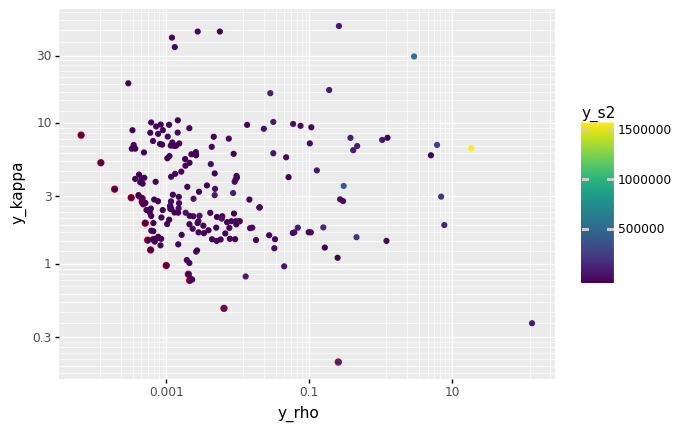

<ggplot: (8776544255073)>

In [17]:
(
    df_data
    >> ggplot(aes("y_rho", "y_kappa", color="y_s2"))
    + geom_point(
        data=df_data
        >> gr.tf_mutate(pareto=gr.pareto_min(DF.y_rho, DF.y_kappa))
        >> gr.tf_filter(DF.pareto),
        color="red",
        size=2,
    )
    + geom_point()
    
    + scale_x_log10()
    + scale_y_log10()
)


Rather than finding "the best" material, we will instead seek to identify a set of materials that represent the best among the tradeoffs we must make. This set is made formal in the [Pareto frontier](https://en.wikipedia.org/wiki/Pareto_efficiency#Pareto_frontier).


## Modeling



In [7]:
var_features = (
    df_data
    >> gr.tf_select(gr.contains("x"))
).columns

out_responses = ["y_rho", "y_kappa", "y_s2"]


In [8]:
from grama.fit import ft_lolo

In [9]:
ft_base = ft_lolo(
    var=var_features,
    out=out_responses,
)


In [11]:
(
    df_data
    >> gr.tf_kfolds(
        ft=ft_base,
        out=out_responses,
        k=5,
    )
)


... tran_kfolds is using default summaries mse and rsq


,mse_y_s2,rsq_y_s2,mse_y_kappa,rsq_y_kappa,mse_y_rho,rsq_y_rho,_kfold
0,5.090712e+10,0.198061,53.504890,-0.216875,7.401069,0.091167,0
1,1.435635e+09,-0.064291,7.533456,0.256434,4.025003,-4145.576205,1
2,8.168802e+09,-3.768710,11.931998,0.753681,413.198532,-0.028358,2
3,3.006806e+09,0.355212,32.939123,0.639518,4.301916,-0.154988,3
4,5.884180e+08,0.270586,16.823462,0.648011,22.687855,-586.783934,4
